In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [174]:
data = pd.read_csv('data/48_Industry_Portfolios.csv', skiprows=11, nrows=1181, index_col=0)
data.index = pd.to_datetime(data.index, format='%Y%m')
data = data[data.index >= pd.Timestamp('2019-11-01')]
data.tail()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2024-07-01,5.11,4.06,3.57,3.04,11.69,8.51,-3.96,3.15,-1.07,-2.36,...,11.79,0.20,6.44,-0.13,-2.66,7.46,8.44,19.38,6.73,5.90
2024-08-01,2.32,5.09,5.38,0.88,7.96,-1.92,5.98,1.69,6.30,5.78,...,1.24,2.45,-1.21,0.75,5.47,2.20,4.33,0.56,0.98,6.27
2024-09-01,2.76,0.95,0.77,1.32,-1.31,3.37,4.29,-2.33,1.05,5.76,...,3.27,2.50,-0.72,4.09,5.43,-2.00,-1.02,5.99,2.61,-1.35
2024-10-01,4.39,-4.28,-7.69,-5.15,8.46,0.29,4.02,0.61,-5.81,-6.12,...,-3.61,1.37,-1.58,-0.96,-0.64,5.12,-4.31,0.69,6.53,-2.65
2024-11-01,3.02,0.63,0.28,-0.40,2.15,4.00,14.15,5.40,7.01,7.85,...,6.22,8.43,11.84,10.25,6.25,13.21,8.33,7.82,14.13,7.44


# Part A

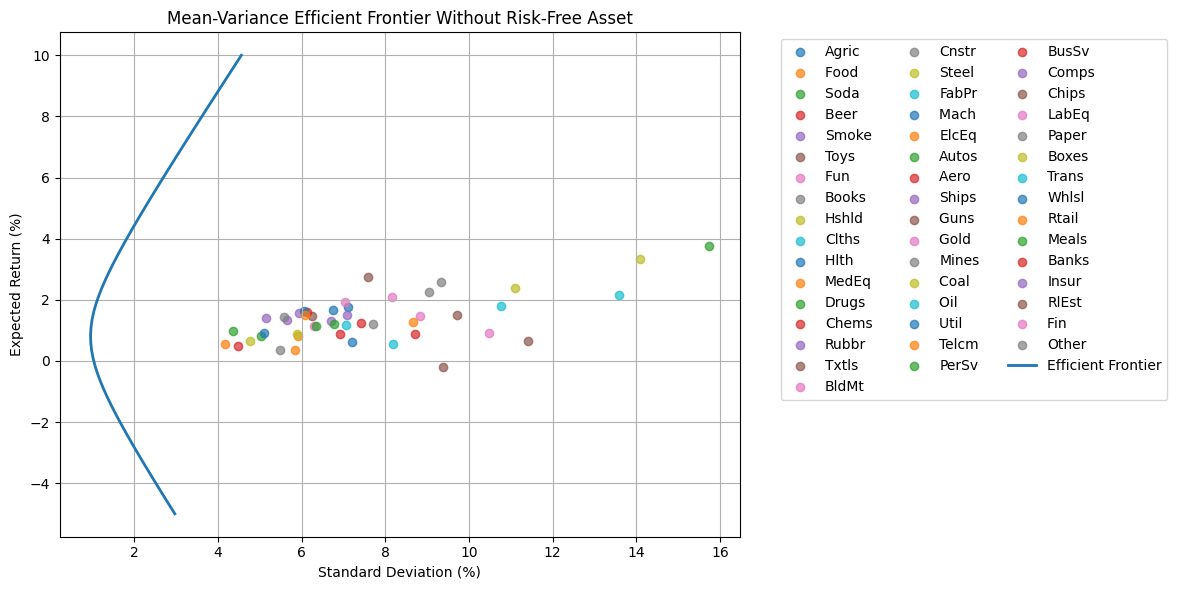

In [175]:
# Question 1
returns = data.mean().values
cov_matrix = data.cov().values
num_assets = len(returns)

def portfolio_variance(weights, cov_matrix):
    return 0.5 * weights.T @ cov_matrix @ weights

def constraint_sum_weights(weights):
    return np.sum(weights) - 1

def constraint_portfolio_return(weights, mu, returns):
    return returns.T @ weights - mu

expected_returns = np.linspace(-5, 10, 60)
efficient_portfolios = []

# find efficient frontier
for mu in expected_returns:
    # Constraints
    constraints = [
        {"type": "eq", "fun": constraint_sum_weights},
        {"type": "eq", "fun": lambda w, mu=mu: constraint_portfolio_return(w, mu, returns)},
    ]
    
    initial_weights = np.ones(num_assets) / num_assets

    
    result = minimize(
        portfolio_variance,  
        initial_weights, 
        args=(cov_matrix,),
        method="SLSQP",
        constraints=constraints,
    )
    
    if result.success:
        weights = result.x
        variance = portfolio_variance(weights, cov_matrix)
        efficient_portfolios.append((mu, variance))

# store efficient frontier in a dataframe
efficient_df = pd.DataFrame(efficient_portfolios, columns=["Return", "Variance"])

#plot efficient frontier
plt.figure(figsize=(12, 6))

for i, industry in enumerate(data.columns):
    industry_return = returns[i]
    industry_std = np.sqrt(cov_matrix[i, i])
    plt.scatter(industry_std, industry_return, label=industry, alpha=0.7)

# Plot the efficient frontier
plt.plot(
    np.sqrt(efficient_df["Variance"]),
    efficient_df["Return"], 
    marker="", 
    label="Efficient Frontier", 
    linewidth=2
)

plt.title("Mean-Variance Efficient Frontier Without Risk-Free Asset")
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Expected Return (%)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.tight_layout()
plt.show()

In [176]:
# Question 2
risk_free = pd.read_csv('data/F-F_Research_Data_Factors.CSV', skiprows=3, nrows=1181, index_col=0)
risk_free.index = pd.to_datetime(risk_free.index, format='%Y%m')
risk_free = risk_free[risk_free.index >= pd.Timestamp('2019-11-01')]

# set `RF` to mean value for each period
risk_free['RF'] = risk_free['RF'].mean().round(2)

# subtract 'RF' from each industry return
data_excess = data.sub(risk_free['RF'], axis=0)

# concatenate 'RF' to data_excess
data_excess = pd.concat([risk_free['RF'], data_excess], axis=1)
data_excess.head()

,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2019-11-01,0.19,-0.87,3.24,-0.37,-0.79,5.33,3.93,6.22,-0.98,-1.52,...,1.61,2.58,3.98,1.87,2.50,4.85,6.32,6.71,7.00,4.22
2019-12-01,0.19,10.95,2.87,3.78,1.20,3.03,-1.21,4.72,3.07,2.40,...,0.40,-0.41,2.25,1.02,2.08,3.06,2.02,5.39,0.60,1.54
2020-01-01,0.19,-3.50,-1.57,5.02,2.51,-3.85,-3.56,0.82,-4.53,0.20,...,-1.16,-0.34,-3.18,0.95,1.31,-3.89,-3.05,-2.05,2.79,0.63
2020-02-01,0.19,-6.30,-9.49,-8.38,-7.66,-6.90,-17.30,-3.87,-6.84,-8.65,...,-7.41,-11.08,-9.56,-6.22,-9.55,-11.68,-9.07,-10.24,-10.66,-8.62
2020-03-01,0.19,-11.31,-4.43,-15.63,-10.11,-6.95,-19.04,-16.48,-22.84,-6.94,...,-9.88,-17.00,-18.01,-4.67,-22.31,-24.09,-12.93,-36.14,-17.05,-15.18


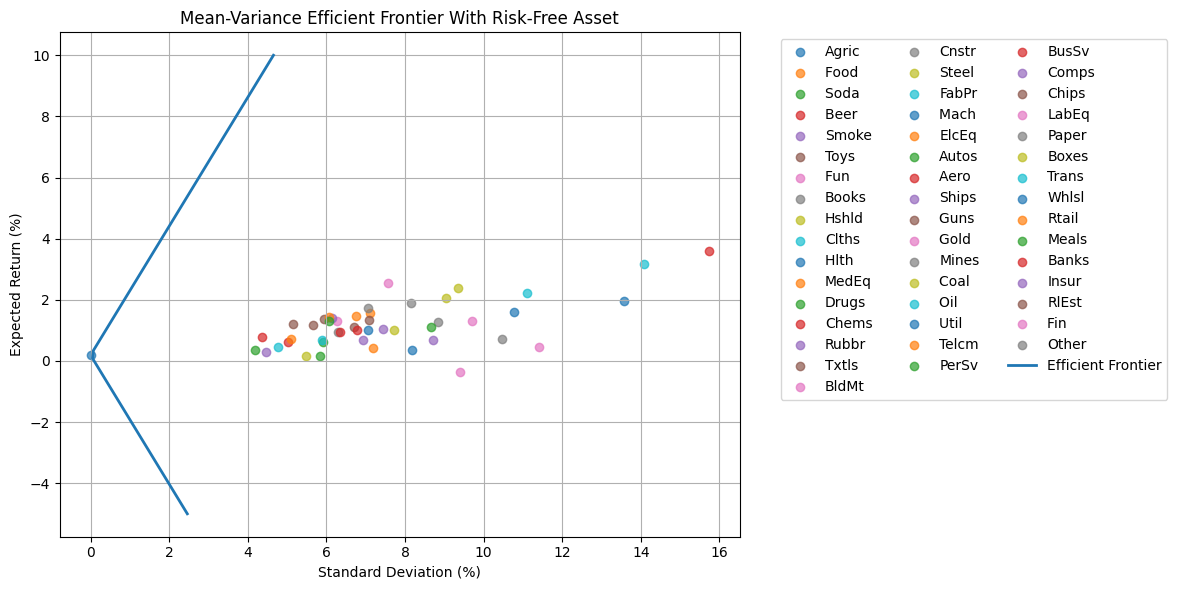

In [ ]:
# solve for optimal portfolio with risk free asset

# calculate excess returns
excess_returns = data_excess.mean().values
cov_excess = data_excess.cov().values
num_assets = len(excess_returns)
R = 0.19

expected_returns = np.linspace(-5, 10, 60)
efficient_portfolios = []

# define new objective function for risk free asset with excess returns
def portfolio_variance_with_rf(weights, cov_excess):
    return 0.5 * weights[1:].T @ cov_excess @ weights[1:]

# define new return constraint for risk free asset with excess returns
def constraint_portfolio_return_with_rf(weights, mu, excess_returns, R):
    return excess_returns.T @ weights[1:] + R * weights[0] - mu

# define new sum of weights constraint for risk free asset
def constraint_sum_weights_with_rf(weights):
    return np.sum(weights) - 1

# find efficient frontier with risk free asset
for mu in expected_returns:
    # Constraints
    constraints = [
        {"type": "eq", "fun": constraint_sum_weights_with_rf},
        {"type": "eq", "fun": lambda w, mu=mu: constraint_portfolio_return_with_rf(w, mu, excess_returns, R)},
    ]
    
    initial_weights = np.ones(num_assets + 1) / (num_assets + 1)
    
    result = minimize(
        portfolio_variance_with_rf,  
        initial_weights, 
        args=(cov_excess,),
        method="SLSQP",
        constraints=constraints,
    )
    
    if result.success:
        weights = result.x
        variance = portfolio_variance_with_rf(weights, cov_excess)
        efficient_portfolios.append((mu, variance))

# store efficient frontier in a dataframe
efficient_df = pd.DataFrame(efficient_portfolios, columns=["Return", "Variance"])

#plot efficient frontier
plt.figure(figsize=(12, 6))

for i, industry in enumerate(data.columns):
    industry_return = excess_returns[i]
    industry_std = np.sqrt(cov_excess[i, i])
    plt.scatter(industry_std, industry_return, label=industry, alpha=0.7)


# Plot the efficient frontier
plt.plot(
    np.sqrt(efficient_df["Variance"]),
    efficient_df["Return"], 
    marker="", 
    label="Efficient Frontier", 
    linewidth=2
)

plt.title("Mean-Variance Efficient Frontier With Risk-Free Asset")
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Expected Return (%)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.tight_layout()
plt.show()

In [189]:
# Question 3

constraints = [
    {"type": "eq", "fun": constraint_sum_weights_with_rf},
    {"type": "eq", "fun": lambda w, mu=R: constraint_portfolio_return_with_rf(w, mu, excess_returns, R)},
]

initial_weights = np.ones(num_assets + 1) / (num_assets + 1)

result = minimize(
    portfolio_variance_with_rf,  
    initial_weights, 
    args=(cov_excess,),
    method="SLSQP",
    constraints=constraints,
)


#### Mean-Variance Portfolio Problem
No risk free asset:
- Assume investors' preferences can be represented by a derived utility function $V(\hat{Z}, \sigma^2)$. The expected return and variance on the portfolio are
$$\bar{Z} = \textbf{w}'\bar{\textbf{z}}+w_0 R = \sum_{i=0}^N w_i\bar{z}_i$$
$$\sigma^2 = \textbf{w}'\mathbf{\Sigma}\textbf{w} = \sum_{i=1}^N\sum_{j=1}^N w_iw_j\sigma_{ij}$$

#### Mean-Variance with no risk free asset:
First choose weights to minimize variance for a given return $\mu$:

$$\min \frac{1}{2} \mathbf{w}' \mathbf{\Sigma} \mathbf{w}$$

subject to:

$$\mathbf{1}'\mathbf{w} = 1$$

$$\bar{\mathbf{z}}' \mathbf{w} = \mu$$

#### Mean-Variance with risk free asset:

$$\min \frac{1}{2} \mathbf{w}' \mathbf{\Sigma} \mathbf{w}$$

subject to:

$$(\bar{\mathbf{z}} - R\mathbf{1})'\mathbf{w} = \mu - R$$